# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-12-08 18:29:40--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  52.3MB/s    in 3.7s    

2021-12-08 18:29:44 (46.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-12-08 18:29:44--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  55.6MB/s    in 1.1s    

2021-12-08 18:29:45 (55.6 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-12-08 18:29:45--
Total wall clock time: 5.1s
Downloaded: 2 files, 235M i

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [12]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:


summary(nn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
         Flattener-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 41,290
Trainable params: 41,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.10
Params size (MB): 0.16
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [7]:
def train_model_simple(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    accuracy = 0
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
      for _, (x,y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        indices2 = torch.argmax(pred, 1)
        correct_samples += torch.sum(indices2 == y)
        total_samples += y.shape[0]
        accuracy = float(correct_samples) / total_samples
        
    return accuracy

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [8]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


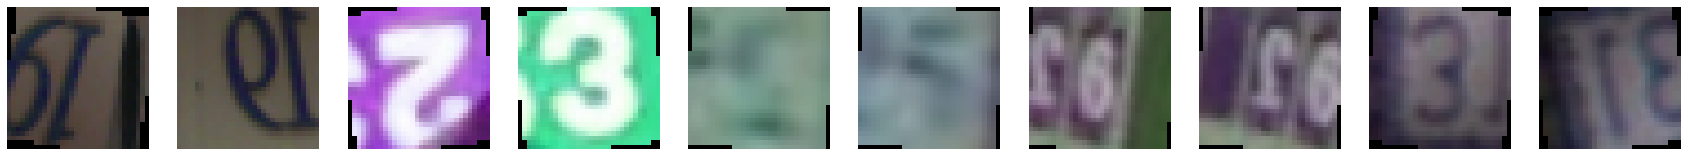

In [9]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [10]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    #transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [13]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)
loss_history, train_history, val_history = train_model_simple(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.541512, Train accuracy: 0.475736, Val accuracy: 0.722476
Average loss: 0.805641, Train accuracy: 0.750230, Val accuracy: 0.781312
Average loss: 0.694917, Train accuracy: 0.785449, Val accuracy: 0.805611
Average loss: 0.640299, Train accuracy: 0.803672, Val accuracy: 0.828954
Average loss: 0.601152, Train accuracy: 0.817322, Val accuracy: 0.833936


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),    
            nn.Conv2d(16, 120, 5, padding=0),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84,10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.763014, Train accuracy: 0.383237, Val accuracy: 0.720429
Average loss: 0.832594, Train accuracy: 0.740334, Val accuracy: 0.780902
Average loss: 0.672154, Train accuracy: 0.793741, Val accuracy: 0.823971
Average loss: 0.611972, Train accuracy: 0.813005, Val accuracy: 0.780015
Average loss: 0.571754, Train accuracy: 0.825069, Val accuracy: 0.836735
Average loss: 0.540110, Train accuracy: 0.834590, Val accuracy: 0.850522
Average loss: 0.525572, Train accuracy: 0.839658, Val accuracy: 0.834687
Average loss: 0.505159, Train accuracy: 0.845801, Val accuracy: 0.855778
Average loss: 0.489400, Train accuracy: 0.851517, Val accuracy: 0.856870
Average loss: 0.480854, Train accuracy: 0.854520, Val accuracy: 0.848748


# Подбор гиперпараметров

In [ ]:
import random

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        sheduler.step()

        print("Epoch %i. Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

random_lr = random.sample(learning_rates, 3)
random_reg = random.sample(reg, 3)
random_ae = random.sample(anneal_epochs, 3) 

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 
# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
print(random_lr)
print(random_reg)
print(random_ae)

Epoch 0. Average loss: 1.955257, Train accuracy: 0.309644, Val accuracy: 0.642482
Epoch 1. Average loss: 0.960445, Train accuracy: 0.698376, Val accuracy: 0.773326
Epoch 2. Average loss: 0.725357, Train accuracy: 0.776217, Val accuracy: 0.784725
Epoch 3. Average loss: 0.645868, Train accuracy: 0.799662, Val accuracy: 0.799604
Epoch 4. Average loss: 0.602301, Train accuracy: 0.813347, Val accuracy: 0.826360
Epoch 0. Average loss: 0.569556, Train accuracy: 0.825973, Val accuracy: 0.824722
Epoch 1. Average loss: 0.550886, Train accuracy: 0.829130, Val accuracy: 0.826838
Epoch 2. Average loss: 0.537759, Train accuracy: 0.834522, Val accuracy: 0.836257
Epoch 3. Average loss: 0.527097, Train accuracy: 0.838139, Val accuracy: 0.850932
Epoch 4. Average loss: 0.517206, Train accuracy: 0.841313, Val accuracy: 0.843492
Epoch 0. Average loss: 0.508923, Train accuracy: 0.845152, Val accuracy: 0.847655
Epoch 1. Average loss: 0.498072, Train accuracy: 0.848616, Val accuracy: 0.852843
Epoch 2. Average

In [ ]:
for lrp in random_lr:
  for ae in random_ae:
    for r in random_reg:
      optimizer = optim.SGD(lenet_model.parameters(), lr=lrp, weight_decay=r)
      sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ae, gamma=0.5)
      loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, sheduler)
      run_record[Hyperparams(lrp,ae,r)] = RunResult(lenet_model,train_history,val_history,val_history[len(val_history)-1])

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [14]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        sheduler.step()

        print("Epoch %i. Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [24]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [51]:
best_model = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(128), 
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),   
            Flattener(),
            nn.Linear(128*2*2, 10),
            #nn.ReLU(inplace=True),
            #nn.Linear(256, 10),
          )


best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=1e-1, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
#optimizer = optim.SGD(best_model.parameters(), lr=1e-1, weight_decay=1e-4)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [52]:
summary(best_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
              ReLU-2          [-1, 128, 32, 32]               0
         MaxPool2d-3            [-1, 128, 8, 8]               0
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 128, 8, 8]         147,584
              ReLU-6            [-1, 128, 8, 8]               0
         MaxPool2d-7            [-1, 128, 2, 2]               0
       BatchNorm2d-8            [-1, 128, 2, 2]             256
            Conv2d-9            [-1, 128, 2, 2]         147,584
             ReLU-10            [-1, 128, 2, 2]               0
      BatchNorm2d-11            [-1, 128, 2, 2]             256
        Flattener-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 304,650
Trainable params:

In [53]:
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20, sheduler)

Epoch 0. Average loss: 1.826354, Train accuracy: 0.434512, Val accuracy: 0.633745
Epoch 1. Average loss: 1.276167, Train accuracy: 0.624970, Val accuracy: 0.617637
Epoch 2. Average loss: 1.217307, Train accuracy: 0.648824, Val accuracy: 0.554365
Epoch 3. Average loss: 1.348093, Train accuracy: 0.634611, Val accuracy: 0.296226
Epoch 4. Average loss: 1.429655, Train accuracy: 0.630686, Val accuracy: 0.704594
Epoch 5. Average loss: 1.082644, Train accuracy: 0.677081, Val accuracy: 0.627739
Epoch 6. Average loss: 1.376359, Train accuracy: 0.632734, Val accuracy: 0.614566
Epoch 7. Average loss: 0.797970, Train accuracy: 0.751527, Val accuracy: 0.763224
Epoch 8. Average loss: 0.838082, Train accuracy: 0.739173, Val accuracy: 0.616954
Epoch 9. Average loss: 0.880252, Train accuracy: 0.729106, Val accuracy: 0.699065
Epoch 10. Average loss: 0.868101, Train accuracy: 0.730471, Val accuracy: 0.744796
Epoch 11. Average loss: 0.877411, Train accuracy: 0.728953, Val accuracy: 0.568971
Epoch 12. Aver

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [47]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.8111170866625691
